In [1]:
try:
    # always cd to the right directory in google colab
    from google.colab import drive
    drive.mount('/content/drive')
    %cd "/content/drive/MyDrive/Colab Notebooks/deep_branching_with_domain"
except:
    pass

import os
import sys
import math
import time
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from functools import partial
# add parent directory to system so that we can import the modules correctly
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from branch.galerkin import DGMNet
from branch.branch import Net

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Implementation with closed-form formula given by Borodin

In [2]:
def conditional_probability_to_survive(
    t,
    x,
    y,
    k_arr=range(-5, 5),
    lower_bound=-10,
    upper_bound=10,
):
    # in case lower_bound & upper_bound are not tensor
    if not torch.is_tensor(lower_bound):
        lower_bound = torch.tensor(lower_bound, device=device)
    if not torch.is_tensor(upper_bound):
        upper_bound = torch.tensor(upper_bound, device=device)

    # transpose (t, x, y)
    # so that the operation with lower_bound, upper_bound is correct
    t = t.unsqueeze(dim=0).transpose(0, -1)
    x, y = x.transpose(0, -1), y.transpose(0, -1)

    # calculate the probability using the formula by Borodin
    ans = 0
    for k in k_arr:
        ans += (
            torch.exp(
                ((y - x) ** 2 - (y - x + 2*k*(upper_bound-lower_bound)) ** 2) 
                / (2 * t)
            )
            - torch.exp(
                ((y - x) ** 2 - (y + x - 2*lower_bound + 2*k*(upper_bound-lower_bound)) ** 2) 
                / (2 * t)
            )
        )
    # print(ans.transpose(0, -1).prod(dim=0))
    return ans.transpose(0, -1).prod(dim=0)

def is_x_inside(x, lower_bound=-10, upper_bound=10):
    # in case lower_bound & upper_bound are not tensor
    if not torch.is_tensor(lower_bound):
        lower_bound = torch.tensor(lower_bound, device=device)
    if not torch.is_tensor(upper_bound):
        upper_bound = torch.tensor(upper_bound, device=device)

    # transpose x so that the operation with lower_bound, upper_bound is correct
    x = x.transpose(0, -1)

    return (
        torch.logical_and(lower_bound <= x, x <= upper_bound)
        .transpose(0, -1).all(dim=0)
    )

## Example 1: heat equation

The heat equation
$$
\begin{cases}
& \partial_t u_A(t, x) + \frac{\nu}{2}\Delta u_A(t, x) = 0, \qquad \text{for all } (t, x) \in [0, T] \times \Omega,
\\
& u_A(T, x) = 1_{x \in A}, \qquad \text{for all } x \in \Omega,
\\
& u_A(t, x) = 0, \qquad \text{for all } (t, x) \in [0, T] \times \partial\Omega,
\end{cases}
$$
where
$A = [a, b]$
and
$\Omega = [\text{lo}, \text{hi}]$,
admits the closed-form solution of
\begin{align*}
u_A(t, x) = 
\sum\limits_{k=-\infty}^\infty
& \Phi\left(\frac{b - x + 2k(\text{hi}-\text{lo})}{\sqrt{\nu(T-t)}}\right)
- \Phi\left(\frac{a - x + 2k(\text{hi}-\text{lo})}{\sqrt{\nu(T-t)}}\right)
\\
& - \Phi\left(\frac{b + x - 2\text{lo} + 2k(\text{hi}-\text{lo})}{\sqrt{\nu(T-t)}}\right)
+ \Phi\left(\frac{a + x - 2\text{lo} + 2k(\text{hi}-\text{lo})}{\sqrt{\nu(T-t)}}\right).
\end{align*}
On the other hand, when $\text{hi} \to \infty$ and $\text{lo} \to -\infty$, the solution is given by
$$
u_A(t, x) = 
\Phi\left(\frac{b - x}{\sqrt{\nu(T-t)}}\right)
- \Phi\left(\frac{a - x}{\sqrt{\nu(T-t)}}\right).
$$

In [3]:
problem_name = "heat_equation"
nu = 1
y, eps = 0, 1
a, b = y - eps, y + eps

# function definition
deriv_map = np.array([0]).reshape(-1, 1)
def f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    """
    return torch.zeros_like(y[0])

def phi_example(x, coordinate=0):
    return torch.logical_and(x[0] <= b, x[0] >= a).float()

def exact_example(t, x, T, coordinate=0, lower_bound=-10, upper_bound=10, with_bound=False, k_arr=range(-5, 5)):
    if t == T:
        return np.logical_and(x[0] <= b, x[0] >= a)
    else:
        normal_std = math.sqrt(nu * (T - t))
        if not with_bound:
            # without bound
            return norm.cdf((b - x[0]) / normal_std) - norm.cdf((a - x[0]) / normal_std)
        else:
            # with bound
            ans = 0
            for k in k_arr:
                mu = x[0] - 2 * k * (upper_bound - lower_bound)
                ans += (norm.cdf((b - mu) / normal_std) - norm.cdf((a - mu) / normal_std))
                mu = 2 * lower_bound - 2 * k * (upper_bound - lower_bound) - x[0]
                ans -= (norm.cdf((b - mu) / normal_std) - norm.cdf((a - mu) / normal_std))
            return ans

t_lo, x_lo, x_hi = 0., -2, 2

Logs are saved in /home/nguwijy/repo/deep_branching_with_domain/logs/tmp
Patch 0: generation of u samples take 39.18351912498474 seconds.
Patch  0: epoch    0 with loss 1.11E+01


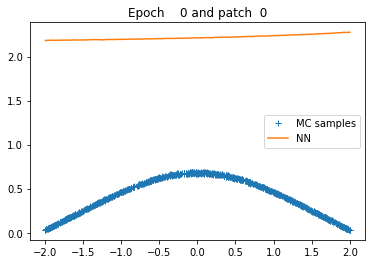

Patch  0: epoch  500 with loss 2.03E-04


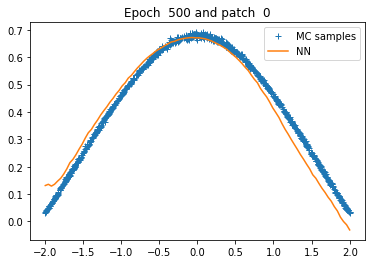

Patch  0: epoch 1000 with loss 1.99E-05


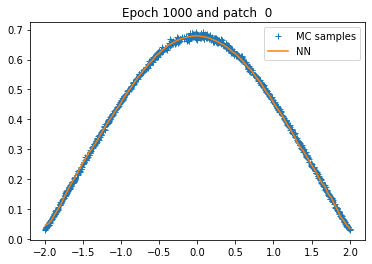

Patch  0: epoch 1500 with loss 1.92E-05


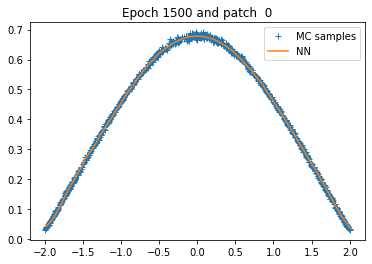

Patch  0: epoch 2000 with loss 5.29E-05


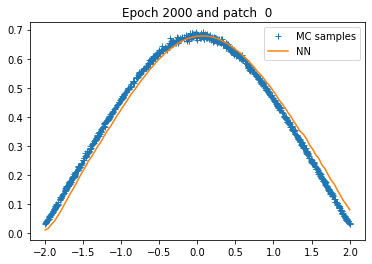

Patch  0: epoch 2500 with loss 1.79E-05


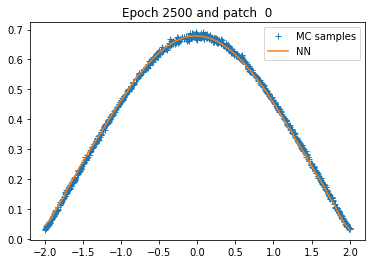

Patch  0: epoch 3000 with loss 2.08E-05


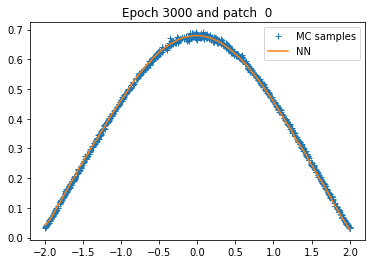

Patch  0: epoch 3500 with loss 2.09E-05


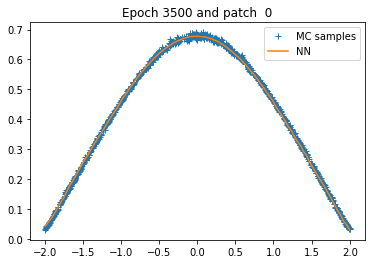

Patch  0: epoch 4000 with loss 3.86E-05


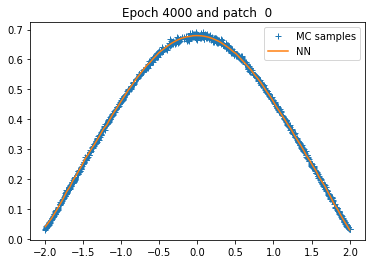

Patch  0: epoch 4500 with loss 1.96E-05


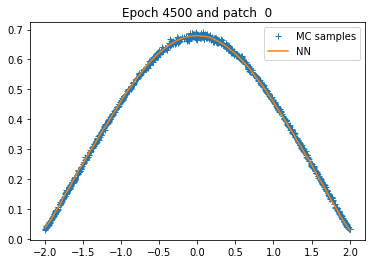

Patch  0: epoch 4999 with loss 6.32E-05


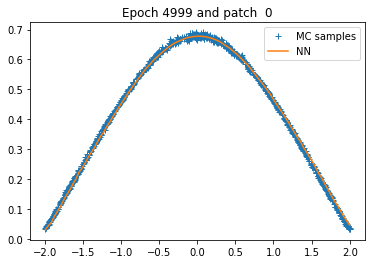

Patch 0: training of u with 5000 epochs take 35.098859548568726 seconds.


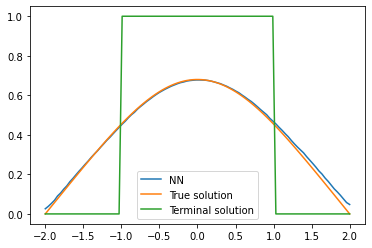

In [4]:
# based on BM discretization
patches = 1
T = patches * 1.0

# define NN and train
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    # conditional_probability_to_survive=partial(conditional_probability_to_survive, lower_bound=x_lo, upper_bound=x_hi),
    is_x_inside=partial(is_x_inside, lower_bound=x_lo, upper_bound=x_hi),
    bm_discretization_steps=100,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_patches=patches,
    overtrain_rate=0.,
    save_for_best_model=False,
    save_as_tmp=True,
)
model.train_and_eval(debug_mode=True)
model.compare_with_exact(exact_fun=partial(exact_example, lower_bound=x_lo, upper_bound=x_hi, with_bound=True))

Logs are saved in /home/nguwijy/repo/deep_branching_with_domain/logs/tmp
Patch 0: generation of u samples take 3.9242827892303467 seconds.
Patch  0: epoch    0 with loss 1.09E+01


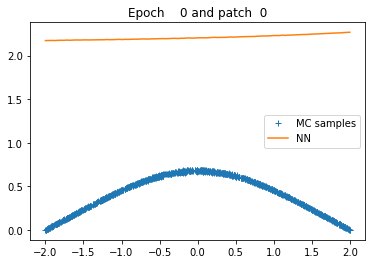

Patch  0: epoch  500 with loss 2.14E-05


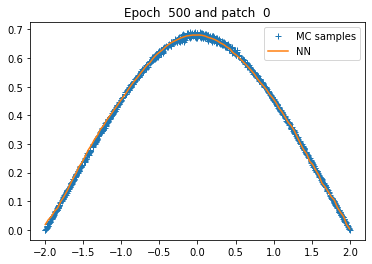

Patch  0: epoch 1000 with loss 1.47E-05


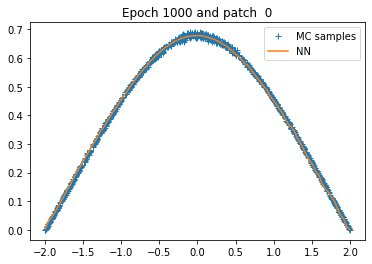

Patch  0: epoch 1500 with loss 4.72E-05


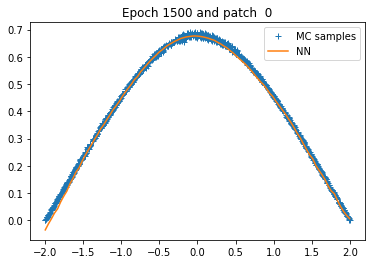

Patch  0: epoch 2000 with loss 1.43E-05


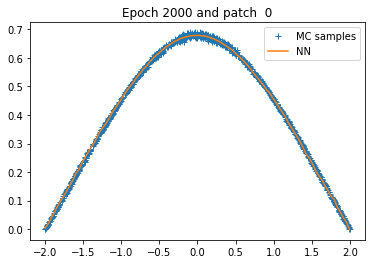

Patch  0: epoch 2500 with loss 1.44E-05


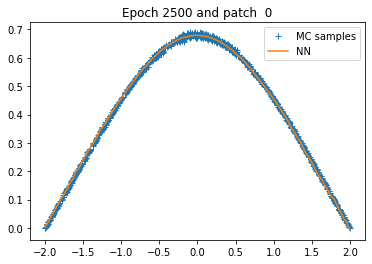

Patch  0: epoch 3000 with loss 1.43E-05


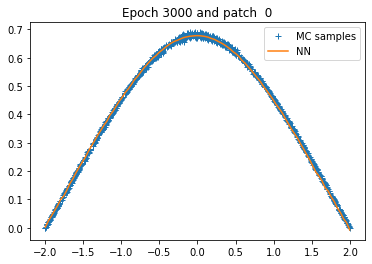

Patch  0: epoch 3500 with loss 1.95E-04


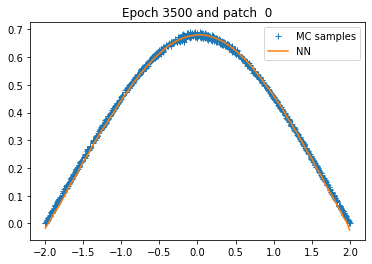

Patch  0: epoch 4000 with loss 1.53E-05


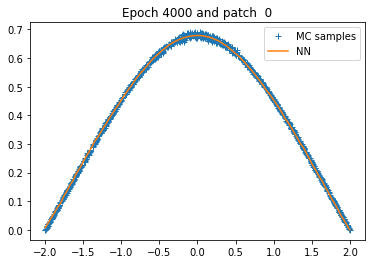

Patch  0: epoch 4500 with loss 2.32E-05


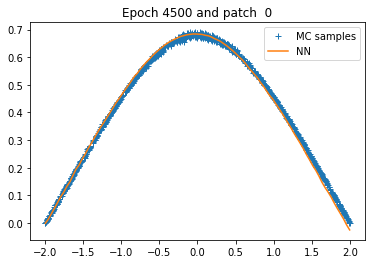

Patch  0: epoch 4999 with loss 1.72E-05


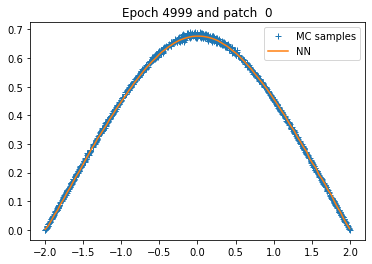

Patch 0: training of u with 5000 epochs take 35.63218545913696 seconds.


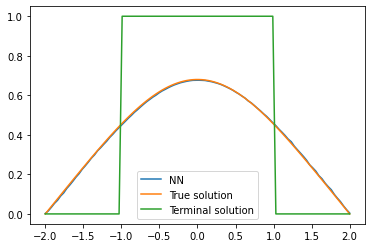

In [5]:
# based on the formula by Borodin
patches = 1
T = patches * 1.0

# define NN and train
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    conditional_probability_to_survive=partial(conditional_probability_to_survive, lower_bound=x_lo, upper_bound=x_hi),
    is_x_inside=partial(is_x_inside, lower_bound=x_lo, upper_bound=x_hi),
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_patches=patches,
    overtrain_rate=0.,
    save_for_best_model=False,
    save_as_tmp=True,
)
model.train_and_eval(debug_mode=True)
model.compare_with_exact(exact_fun=partial(exact_example, lower_bound=x_lo, upper_bound=x_hi, with_bound=True))